In [ ]:
!pip3 install librosa

In [24]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

from app.website.extract_features import extract_mfcc, zero_crossing_rate, get_audio_info

2.5.0


## Dataset

We check given directory to find all available *.wav* files.

In [25]:
# helper
def contains_number(s):
    return any(i.isdigit() for i in s)

In [26]:
#check source directory and find classes
source_dir = './vox_dev_wav/wav/'
# source_dir = './audio/'
speakers = [name for name in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, name))]
print(speakers)
raw = []
for speaker in speakers:
    path = os.path.join(source_dir, speaker) + '/'
    print('checking dir:', path)
    folders = [f for f in os.listdir(path) if not f.startswith('.') ]
    for folder in folders:
        clip_path = os.path.join(path, folder) + '/'
        print(clip_path)
        clips = [f for f in os.listdir(clip_path) if f.endswith('.wav')]
        for clip in clips:
            raw.append({'speaker': speaker, 'path':clip_path+clip})

['id10009', 'id10007', 'id10006', 'id10001', 'id10008', 'id10012', 'id10015', 'id10014', 'id10013', 'id10004', 'id10003', 'id10002', 'id10005', 'id10016', 'id10011', 'id10018', 'id10020', 'id10019', 'id10010', 'id10017']
checking dir: ./vox_dev_wav/wav/id10009/
./vox_dev_wav/wav/id10009/HCGXIgKsozU/
./vox_dev_wav/wav/id10009/AtavJVP4bCk/
./vox_dev_wav/wav/id10009/x_HdUZuSusA/
./vox_dev_wav/wav/id10009/seo9TTTEoE4/
./vox_dev_wav/wav/id10009/7hpSiT9_gCE/
./vox_dev_wav/wav/id10009/JrwqvWr5_VE/
./vox_dev_wav/wav/id10009/FOFbkVlz-wQ/
./vox_dev_wav/wav/id10009/JntZkGsH2Cc/
./vox_dev_wav/wav/id10009/aFttHpeaXaQ/
./vox_dev_wav/wav/id10009/vy8sQ82o0fM/
./vox_dev_wav/wav/id10009/qdop2-gjKBQ/
./vox_dev_wav/wav/id10009/VM8gJWbQsEY/
./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/
./vox_dev_wav/wav/id10009/sQIqfA-I_Ew/
checking dir: ./vox_dev_wav/wav/id10007/
./vox_dev_wav/wav/id10007/10Oe0XETA0s/
./vox_dev_wav/wav/id10007/ny4iV7xwhRM/
./vox_dev_wav/wav/id10007/HxfxcxUXPDA/
./vox_dev_wav/wav/id10007/G0lVD5d0

In [27]:
df = pd.DataFrame(raw)
# df = df[:100]
print(df.shape)
df.head()

(2787, 2)


,speaker,path
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav
1,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00009.wav
2,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00008.wav
3,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00006.wav
4,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00007.wav


## Preprocessing and Feuture Extraction

* We split the dataset as 70% train and 30% test. The split is performed per speaker and not the entire dataset
* Then, we extract MFCC and Delta features

In [28]:
# create test dataframe, keep 0.7 of each speaker as train and 0.3 as test
train_split = 0.7
df_train_list = []
df_test_list = []
for id in df['speaker'].unique():
    speaker = df.loc[df['speaker'] == id]
    #suffle and split dataset
    speaker = speaker.sample(frac=1, replace=False, random_state=42)
    train_indices = int(round(train_split*len(speaker)))
    train = speaker[:train_indices]
    test = speaker[:len(speaker) - train_indices]
    df_train_list.append(train)
    df_test_list.append(test)

df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
print(f'Train set size: {df_train.shape}, Test set size {df_test.shape}')

# sanity check, check if both train and test sets have same speakers
b = set(df_train['speaker'].unique()) == set(df_test['speaker'].unique())
b

Train set size: (1950, 2), Test set size (837, 2)


True

In [29]:
# get sample rate and clip duration for every clip
df_train[['sr','duration']] = df_train['path'].apply(lambda p: get_audio_info(p))
df_test[['sr','duration']] = df_test['path'].apply(lambda p: get_audio_info(p))

df_train.head()

,speaker,path,sr,duration
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,16000.0,4.640062
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,16000.0,5.720063
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,16000.0,5.640062
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,16000.0,5.680063
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,16000.0,6.200062


In [30]:
print(f'{df_train.describe()} \n {df_test.describe()}')

            sr     duration
count   1950.0  1950.000000
mean   16000.0     7.688083
std        0.0     4.507359
min    16000.0     3.960062
25%    16000.0     4.840063
50%    16000.0     6.240062
75%    16000.0     8.960062
max    16000.0    61.680062 
             sr    duration
count    837.0  837.000000
mean   16000.0    7.755045
std        0.0    4.491689
min    16000.0    3.960062
25%    16000.0    4.880063
50%    16000.0    6.360062
75%    16000.0    8.920063
max    16000.0   37.280062


In [31]:
# number of mfccs per clip
n_mfcc = splits = 13

df_train[['mfcc','delta']] = df_train['path'].apply(lambda p: extract_mfcc(p, n_mfcc))
df_test[['mfcc','delta']] = df_test['path'].apply(lambda p: extract_mfcc(p, n_mfcc))

In [32]:
# extract Zero Crossing Rate
df_train[['zcr']] = df_train['path'].apply(lambda p: zero_crossing_rate(p, splits))
df_test[['zcr']] = df_test['path'].apply(lambda p: zero_crossing_rate(p, splits))

In [33]:
df_train.head()

,speaker,path,sr,duration,mfcc,delta,zcr
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,16000.0,4.640062,"[-196.19745, 96.77209, -9.442002, 22.09873, -2...","[-0.29390892, -0.18999796, -0.014305613, 0.165...","[0.06953932387458399, 0.13154668067962866, 0.0..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,16000.0,5.720063,"[-385.69135, 122.257576, -14.257886, -23.04002...","[0.08598741, -0.07328853, 0.024153156, 0.01808...","[0.09745702514561727, 0.16309134820286972, 0.0..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,16000.0,5.640062,"[-223.81839, 86.769295, -17.60496, 23.541613, ...","[-0.16981685, 0.023842582, 0.12981227, 0.07679...","[0.2788184438040346, 0.25230547550432275, 0.25..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,16000.0,5.680063,"[-159.21338, 96.507286, -21.005232, 2.2055504,...","[-0.1431608, 0.0911606, 0.027648797, 0.0220658...","[0.14064959221633996, 0.1417942481041637, 0.10..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,16000.0,6.200062,"[-204.95496, 92.93275, -16.543903, 7.745483, 2...","[-0.039691795, 0.113837615, -0.073666826, -0.0...","[0.19740464018875345, 0.14195831694848604, 0.1..."


In [34]:
df_test.head()

,speaker,path,sr,duration,mfcc,delta,zcr
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,16000.0,4.640062,"[-196.19745, 96.77209, -9.442002, 22.09873, -2...","[-0.29390892, -0.18999796, -0.014305613, 0.165...","[0.06953932387458399, 0.13154668067962866, 0.0..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,16000.0,5.720063,"[-385.69135, 122.257576, -14.257886, -23.04002...","[0.08598741, -0.07328853, 0.024153156, 0.01808...","[0.09745702514561727, 0.16309134820286972, 0.0..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,16000.0,5.640062,"[-223.81839, 86.769295, -17.60496, 23.541613, ...","[-0.16981685, 0.023842582, 0.12981227, 0.07679...","[0.2788184438040346, 0.25230547550432275, 0.25..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,16000.0,5.680063,"[-159.21338, 96.507286, -21.005232, 2.2055504,...","[-0.1431608, 0.0911606, 0.027648797, 0.0220658...","[0.14064959221633996, 0.1417942481041637, 0.10..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,16000.0,6.200062,"[-204.95496, 92.93275, -16.543903, 7.745483, 2...","[-0.039691795, 0.113837615, -0.073666826, -0.0...","[0.19740464018875345, 0.14195831694848604, 0.1..."


In [35]:
#split dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# keep mfcc and delta and zero crossing rate columns
X = df_train.iloc[:,4:7]
# keep speaker colum
y = df_train.iloc[:,0]

le = LabelEncoder()
le.fit(list(y))
num_labels=len(list(le.classes_))

y = le.fit_transform(y)
print(f'Number of speakers is {num_labels}')
# save label encoder to file
np.save('saved_models/classes.npy', le.classes_)
print(type(le))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=21)

X_train = np.hstack((X_train['mfcc'].to_list(),X_train['delta'].to_list(), X_train['zcr'].to_list()))
X_val = np.hstack((X_val['mfcc'].to_list(), X_val['delta'].to_list(), X_val['zcr'].to_list()))
print(f'Train set size: {X_train.shape}, Validation set size {X_val.shape}')

Number of speakers is 20
<class 'sklearn.preprocessing._label.LabelEncoder'>
Train set size: (1365, 39), Validation set size (585, 39)


## Deep Learning Model

In [50]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.3))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer='adam')

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 100)               4000      
_________________________________________________________________
activation_25 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 200)               20200     
_________________________________________________________________
activation_26 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)              

In [51]:
## Train model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 250
num_batch_size = 32


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
checkpointer = ModelCheckpoint(filepath='saved_models/speakers_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model_h = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(X_val, y_val), callbacks=[checkpointer, earlystopping], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/250
43/43 [==============================] - 1s 6ms/step - loss: 16.9147 - accuracy: 0.0777 - val_loss: 2.8245 - val_accuracy: 0.2274

Epoch 00001: val_loss improved from inf to 2.82449, saving model to saved_models/speakers_classification.hdf5
Epoch 2/250
43/43 [==============================] - 0s 4ms/step - loss: 4.4246 - accuracy: 0.0864 - val_loss: 2.9782 - val_accuracy: 0.1094

Epoch 00002: val_loss did not improve from 2.82449
Epoch 3/250
43/43 [==============================] - 0s 7ms/step - loss: 3.3050 - accuracy: 0.1018 - val_loss: 2.9632 - val_accuracy: 0.2017

Epoch 00003: val_loss did not improve from 2.82449
Epoch 4/250
43/43 [==============================] - 0s 8ms/step - loss: 3.0541 - accuracy: 0.1355 - val_loss: 2.9476 - val_accuracy: 0.2103

Epoch 00004: val_loss did not improve from 2.82449
Epoch 5/250
43/43 [==============================] - 0s 4ms/step - loss: 3.0065 - accuracy: 0.1597 - val_loss: 2.9332 - val_accuracy: 0.2188

Epoch 00005: val_loss did 

43/43 [==============================] - 0s 4ms/step - loss: 2.2268 - accuracy: 0.3326 - val_loss: 2.1736 - val_accuracy: 0.3368

Epoch 00036: val_loss improved from 2.19768 to 2.17364, saving model to saved_models/speakers_classification.hdf5
Epoch 37/250
43/43 [==============================] - 0s 3ms/step - loss: 2.2099 - accuracy: 0.3238 - val_loss: 2.1212 - val_accuracy: 0.3538

Epoch 00037: val_loss improved from 2.17364 to 2.12125, saving model to saved_models/speakers_classification.hdf5
Epoch 38/250
43/43 [==============================] - 0s 3ms/step - loss: 2.1863 - accuracy: 0.3363 - val_loss: 2.1048 - val_accuracy: 0.3504

Epoch 00038: val_loss improved from 2.12125 to 2.10484, saving model to saved_models/speakers_classification.hdf5
Epoch 39/250
43/43 [==============================] - 0s 3ms/step - loss: 2.1441 - accuracy: 0.3487 - val_loss: 2.0766 - val_accuracy: 0.3761

Epoch 00039: val_loss improved from 2.10484 to 2.07660, saving model to saved_models/speakers_class

43/43 [==============================] - 0s 4ms/step - loss: 1.1910 - accuracy: 0.6242 - val_loss: 1.0265 - val_accuracy: 0.6889

Epoch 00069: val_loss did not improve from 1.01778
Epoch 70/250
43/43 [==============================] - 0s 3ms/step - loss: 1.2226 - accuracy: 0.6088 - val_loss: 1.0072 - val_accuracy: 0.6923

Epoch 00070: val_loss improved from 1.01778 to 1.00721, saving model to saved_models/speakers_classification.hdf5
Epoch 71/250
43/43 [==============================] - 0s 3ms/step - loss: 1.1987 - accuracy: 0.6330 - val_loss: 1.0239 - val_accuracy: 0.6957

Epoch 00071: val_loss did not improve from 1.00721
Epoch 72/250
43/43 [==============================] - 0s 3ms/step - loss: 1.1420 - accuracy: 0.6418 - val_loss: 0.9867 - val_accuracy: 0.6957

Epoch 00072: val_loss improved from 1.00721 to 0.98672, saving model to saved_models/speakers_classification.hdf5
Epoch 73/250
43/43 [==============================] - 0s 3ms/step - loss: 1.1584 - accuracy: 0.6308 - val_loss:

43/43 [==============================] - 0s 5ms/step - loss: 0.7815 - accuracy: 0.7516 - val_loss: 0.7344 - val_accuracy: 0.7744

Epoch 00105: val_loss did not improve from 0.71399
Epoch 106/250
43/43 [==============================] - 0s 11ms/step - loss: 0.7745 - accuracy: 0.7678 - val_loss: 0.7397 - val_accuracy: 0.7761

Epoch 00106: val_loss did not improve from 0.71399
Epoch 107/250
43/43 [==============================] - 0s 7ms/step - loss: 0.7424 - accuracy: 0.7458 - val_loss: 0.7061 - val_accuracy: 0.7624

Epoch 00107: val_loss improved from 0.71399 to 0.70609, saving model to saved_models/speakers_classification.hdf5
Epoch 108/250
43/43 [==============================] - 0s 3ms/step - loss: 0.7745 - accuracy: 0.7370 - val_loss: 0.7210 - val_accuracy: 0.7641

Epoch 00108: val_loss did not improve from 0.70609
Epoch 109/250
43/43 [==============================] - 0s 4ms/step - loss: 0.7250 - accuracy: 0.7597 - val_loss: 0.7060 - val_accuracy: 0.7863

Epoch 00109: val_loss impr

Epoch 144/250
43/43 [==============================] - 0s 3ms/step - loss: 0.5597 - accuracy: 0.8190 - val_loss: 0.6110 - val_accuracy: 0.8051

Epoch 00144: val_loss did not improve from 0.60133
Epoch 145/250
43/43 [==============================] - 0s 3ms/step - loss: 0.5517 - accuracy: 0.8212 - val_loss: 0.6354 - val_accuracy: 0.8120

Epoch 00145: val_loss did not improve from 0.60133
Epoch 146/250
43/43 [==============================] - 0s 3ms/step - loss: 0.5635 - accuracy: 0.8103 - val_loss: 0.6414 - val_accuracy: 0.7966

Epoch 00146: val_loss did not improve from 0.60133
Epoch 147/250
43/43 [==============================] - 0s 4ms/step - loss: 0.5870 - accuracy: 0.8029 - val_loss: 0.6099 - val_accuracy: 0.8205

Epoch 00147: val_loss did not improve from 0.60133
Epoch 148/250
43/43 [==============================] - 0s 4ms/step - loss: 0.5667 - accuracy: 0.8176 - val_loss: 0.6072 - val_accuracy: 0.8034

Epoch 00148: val_loss did not improve from 0.60133
Epoch 149/250
43/43 [====

43/43 [==============================] - 0s 4ms/step - loss: 0.4652 - accuracy: 0.8381 - val_loss: 0.5661 - val_accuracy: 0.8274

Epoch 00184: val_loss did not improve from 0.54756
Epoch 185/250
43/43 [==============================] - 0s 3ms/step - loss: 0.4930 - accuracy: 0.8462 - val_loss: 0.5603 - val_accuracy: 0.8393

Epoch 00185: val_loss did not improve from 0.54756
Epoch 186/250
43/43 [==============================] - 0s 4ms/step - loss: 0.4404 - accuracy: 0.8557 - val_loss: 0.5700 - val_accuracy: 0.8291

Epoch 00186: val_loss did not improve from 0.54756
Epoch 187/250
43/43 [==============================] - 0s 4ms/step - loss: 0.4662 - accuracy: 0.8542 - val_loss: 0.5824 - val_accuracy: 0.8171

Epoch 00187: val_loss did not improve from 0.54756
Epoch 188/250
43/43 [==============================] - 0s 5ms/step - loss: 0.4772 - accuracy: 0.8432 - val_loss: 0.5793 - val_accuracy: 0.8188

Epoch 00188: val_loss did not improve from 0.54756
Epoch 189/250
43/43 [==================


Epoch 00225: val_loss did not improve from 0.54362
Epoch 226/250
43/43 [==============================] - 0s 8ms/step - loss: 0.4429 - accuracy: 0.8652 - val_loss: 0.6012 - val_accuracy: 0.8205

Epoch 00226: val_loss did not improve from 0.54362
Epoch 227/250
43/43 [==============================] - 0s 8ms/step - loss: 0.3676 - accuracy: 0.8769 - val_loss: 0.5820 - val_accuracy: 0.8308

Epoch 00227: val_loss did not improve from 0.54362
Epoch 228/250
43/43 [==============================] - 0s 7ms/step - loss: 0.3878 - accuracy: 0.8799 - val_loss: 0.5697 - val_accuracy: 0.8325

Epoch 00228: val_loss did not improve from 0.54362
Epoch 229/250
43/43 [==============================] - 0s 6ms/step - loss: 0.4096 - accuracy: 0.8623 - val_loss: 0.6320 - val_accuracy: 0.8085

Epoch 00229: val_loss did not improve from 0.54362
Epoch 230/250
43/43 [==============================] - 0s 6ms/step - loss: 0.4273 - accuracy: 0.8615 - val_loss: 0.6014 - val_accuracy: 0.8188

Epoch 00230: val_loss di

### Check training history

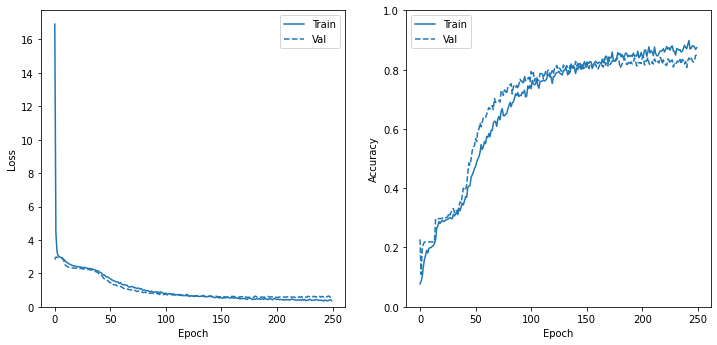

In [53]:
# import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy']#, 'f1_m', 'recall_m']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(model_h)

### Predict and Classification Report

In [54]:
from sklearn.metrics import classification_report

X_test = np.hstack((df_test['mfcc'].to_list(),
                    df_test['delta'].to_list(),
                    df_test['zcr'].to_list()))
print(X_test.shape)
y_true = df_test['speaker']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.classes_[y_pred]
print(y_pred)
print(classification_report(y_true, y_pred, target_names=le.classes_))

(837, 39)
['id10013' 'id10009' 'id10009' 'id10003' 'id10009' 'id10009' 'id10009'
 'id10009' 'id10009' 'id10009' 'id10004' 'id10009' 'id10009' 'id10009'
 'id10009' 'id10009' 'id10009' 'id10009' 'id10007' 'id10007' 'id10007'
 'id10007' 'id10007' 'id10001' 'id10007' 'id10007' 'id10007' 'id10007'
 'id10007' 'id10007' 'id10007' 'id10007' 'id10007' 'id10007' 'id10007'
 'id10007' 'id10007' 'id10007' 'id10007' 'id10007' 'id10014' 'id10007'
 'id10006' 'id10014' 'id10006' 'id10006' 'id10006' 'id10006' 'id10006'
 'id10006' 'id10006' 'id10006' 'id10006' 'id10006' 'id10014' 'id10006'
 'id10006' 'id10006' 'id10006' 'id10006' 'id10006' 'id10006' 'id10006'
 'id10006' 'id10006' 'id10006' 'id10006' 'id10006' 'id10006' 'id10006'
 'id10006' 'id10006' 'id10006' 'id10014' 'id10006' 'id10006' 'id10006'
 'id10006' 'id10006' 'id10006' 'id10001' 'id10001' 'id10001' 'id10001'
 'id10001' 'id10001' 'id10001' 'id10001' 'id10001' 'id10001' 'id10001'
 'id10001' 'id10001' 'id10001' 'id10017' 'id10001' 'id10001' 'id100

## Gausian Mixture Model

In [56]:
from sklearn import mixture
# fit a Gaussian Mixture Model with two components
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X_train)

y_true_gmm = df_test['speaker']

y_pred_gmm = gmm.predict(X_test)
y_pred_gmm = le.classes_[y_pred_gmm]
print(classification_report(y_true_gmm, y_pred_gmm, target_names=le.classes_))

filename = 'saved_models/gaussian_mixture_model.sav'
pickle.dump(gmm, open(filename, 'wb'))


# # display predicted scores by the model as a contour plot
# x = np.linspace(0., 39., 39, endpoint=True)
# # np.linspace(0, 10, N, endpoint=True)
# y = np.linspace(0., 39., 39, endpoint=True)
# X, Y = np.meshgrid(x, y)
# XX = np.array([X.ravel(), Y.ravel()]).T
# Z = -clf.score_samples(XX)
# Z = Z.reshape(X.shape)

# CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
#                  levels=np.logspace(0, 3, 10))
# CB = plt.colorbar(CS, shrink=0.8, extend='both')
# plt.scatter(X_train[:, 0], X_train[:, 1], .8)

# plt.title('Negative log-likelihood predicted by a GMM')
# plt.axis('tight')
# plt.show()


              precision    recall  f1-score   support

     id10001       0.00      0.00      0.00        23
     id10002       0.00      0.00      0.00        39
     id10003       0.07      0.12      0.09        51
     id10004       0.00      0.00      0.00        32
     id10005       0.02      0.06      0.03        18
     id10006       0.02      0.03      0.02        38
     id10007       0.00      0.00      0.00        24
     id10008       0.00      0.00      0.00        32
     id10009       0.00      0.00      0.00        18
     id10010       0.00      0.00      0.00        16
     id10011       0.01      0.03      0.02        36
     id10012       0.00      0.00      0.00        45
     id10013       0.00      0.00      0.00        15
     id10014       0.19      0.24      0.21        29
     id10015       0.00      0.00      0.00        18
     id10016       0.00      0.00      0.00        76
     id10017       0.07      0.07      0.07        46
     id10018       0.00    

In [ ]:
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)